# Instrument Classification
Classify instruments using KNN and MLP

### Overview
1. Download Dataset and Metadata
2. Compute and Create Feature Set
3. K Nearest Neighbor
4. Neural Network (Multilayered Perceptron)
5. Analysis

In [ ]:
import numpy as np
import pandas as pd
import librosa
from librosa import feature
from sklearn import neighbors
from sklearn import neural_network
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

## 1. Download Dataset and Metadata

Dataset downloaded at: *Medley-solos-DB*: https://zenodo.org/record/3464194#.X4G_oi2z3kJ

<blockquote>
V. Lostanlen, C.E. Cella. Deep convolutional networks on the pitch spiral for musical instrument recognition. Proceedings of the International Society for Music Information Retrieval Conference (ISMIR), 2016.
</blockquote>

Audio files contain recordings from 8 different instuments which have already been labeled and separated into training, validation, and test sets. Each audio file is the same length.

In [ ]:
# Load amd Check the csv file

Medley_Data = pd.read_csv("Medley-solos-DB_metadata.csv")
Medley_Data

,subset,instrument,instrument_id,song_id,uuid4
0,test,clarinet,0,0,0e4371ac-1c6a-51ab-fdb7-f8abd5fbf1a3
1,test,clarinet,0,0,33383119-fd64-59c1-f596-d1a23e8a0eff
2,test,clarinet,0,0,b2b7a288-e169-5642-fced-b509c06b11fc
3,test,clarinet,0,0,151b6ee4-313a-58d9-fbcb-bab73e0d426b
4,test,clarinet,0,0,b43999d1-9b5e-557f-f9bc-1b3759659858
...,...,...,...,...,...
21566,validation,violin,7,226,fe4e8e98-6e0f-5a31-f446-99c10e0ac485
21567,validation,violin,7,226,aa606c78-9ee5-507f-f7e9-67c3530faf0f
21568,validation,violin,7,226,05e15c0a-d530-5f3e-fa82-58c55fa44993
21569,validation,violin,7,226,2dd485de-471d-5d8b-fe92-ef957dac021c


In [ ]:
def get_file_name_and_label(uuid, path='Medley-solos-DB/', dataset=Medley_Data):
    """ Returns full file name and path from a uuid
    
    Parameters
    ----------
    
    uuid: str 
        the unique id (uuid4) for the audio file
    
    path: str
        relative path to audio files
        
    dataset: pandas.DataFrame
        the DataFrame to consult (Medley_Data)
    
    Returns
    -------
    
    filename: str
        relative path and filename
    label: int
        the label associated with that filename
    
    """
    
    rd = dataset.loc[ (dataset['uuid4'] == uuid) ]
    file = path + 'Medley-solos-DB' + '_' + str(rd.values[0,0]) + '-'  + str(rd.values[0,2]) + '_' + rd.values[0,4] + '.wav'
    label = rd.values[0,2]
    return(file, label)
                       
def get_ids(subset, path = 'Medley-solos-DB/', dataset = Medley_Data):

    """ Get a np array of all uuids or a subset of files in the dataset
    
    Parameters
    ----------
    
        subset: str
            one of 'training', 'validation, 'test', or 'all'
            
        path: str
            relative path to the audio files
            
        dataset: pd.DataFrame
            The Medley-solos-DB dataframe to search
         
    Returns
    -------
        filename: np.array
            Medley-solos-DB file name (or 0 if not found)
    
    """
    
    file_array = np.array([])
    rd = dataset.loc[ (dataset['subset'] == subset) ]
    if len(rd.index) < 1:
        file_array = np.array([0])
    else:
        k = 0
        for i in range(len(rd.index)):
            file_array = np.append(file_array,rd.iloc[k,4])
            k += 1
    return(file_array)


# Divides up file names into training, validation, and test sets
tracks_train =  get_ids('training')
tracks_validate = get_ids('validation')
tracks_test = get_ids('test')

print("There are {} tracks in the training set".format(len(tracks_train)))
print("There are {} tracks in the validation set".format(len(tracks_validate)))
print("There are {} tracks in the test set".format(len(tracks_test)))

There are 5841 tracks in the training set
There are 3494 tracks in the validation set
There are 12236 tracks in the test set


## 2. Compute and Create Feature Set

In [ ]:
def compute_features(audiofile, n_fft=2048, hop_length=512, n_mels=128, n_mfcc=20):
    """Compute features for an audio file
    
    Parameters
    ----------
    audiofile : str
        name of audio file (with relative directory path)
    n_fft : int
        Number of points for computing the fft
    hop_length : int
        Number of samples to advance between frames
    n_mels : int
        Number of mel frequency bands to use
    n_mfcc : int
        Number of mfccs to compute
    
    Returns
    -------
    features: np.array (1, 2 * (n_mfcc - 1))
        feature vector

    """
    
    ## Load file to time series array
    isinstance(audiofile, str)
    audio, sr = librosa.load(audiofile, mono=True)
    length = audio.size
    
    ## Padd signal for framing
    mod = (length - n_fft) % hop_length
    if mod != 0:
        np.concatenate((audio, np.zeros((mod))))
    
    ## Get mfccs over time
    n_frames = int((length - n_fft) / hop_length + 1)
    mfccs = feature.mfcc(audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mfccs = np.transpose(mfccs)
    mfccs = mfccs[:,1::] # discard first mfcc coefficient
    
    ## Calculate mean and standard deviation
    feature_len = n_mfcc - 1
    mean = np.zeros((1, feature_len))
    std_dev = np.copy(mean)
    
    mfcc_sum = np.sum(mfccs, axis=0)
    mfcc_sum = np.transpose(mfcc_sum)
    for i in range(feature_len):
        mean[:,i] = mfcc_sum[i] / n_frames
        for k in range(n_frames):
            std_dev[:,i] += (mfccs[k,i] - mean[:,i])**2
        
        std_dev[:,i] = np.sqrt(std_dev[:,i])
    
    ## Create feature vector
    feature_vec = np.zeros((1, 2 * feature_len))
    feature_vec[:,0::2] = mean
    feature_vec[:,1::2] = std_dev
    
    return feature_vec # even indices = mean, odd indices = std_dev

In [ ]:
def create_feature_set(id_list):
    """Create feature set from list of input ids.
    
    Parameters
    ----------
    id_list: np.array
        array of uuid (track_test, track_validate, track_train)
    
    Returns
    -------
    
    features: np.array (n_samples, n_features)
        the features
    labels: np.array (n_samples)
        corresponding label for each feature
    
    """
    
    resize = False
    n_samples = id_list.size
    
    files = np.array([])
    features = np.array([])
    labels = np.array([])
    for i in range(n_samples):
        file, label = get_file_name_and_label(id_list[i])
        
        feature = compute_features(file)
        if features.shape.index != feature.shape.index and resize == False:
            n_features = feature.shape[1]
            features = np.empty((n_samples, n_features))
            resize = True
        
        features[i,:] = feature
        labels = np.append(labels, label)
    
    return features, labels

### Get Mean and Standard Deviation


In [ ]:
def get_stats(features):
    """ Get mean and standard deviation of each feature in a set
 
    Parameters
    ---------
    
    features: np.array (n_samples, n_features)
        feature set
 
    Returns
    -------
     
    mean: np.array (n_features)
        mean of input feature set
    std_dev: np.array (n_features)
        standard deviation of input feature set

    """
    
    n_samples, n_features = features.shape
    
    mean = np.empty(n_features)
    std_dev = np.empty(n_features)
    
    for i in range(n_features):
        mean[i] = np.sum(features[:,i]) / n_samples
        for k in range(n_samples):
            std_dev[i] += (features[k,i] - mean[i])**2
        
        std_dev[i] = np.sqrt(std_dev[i])
    
    return mean, std_dev

### Load and Save Train, Validation, Test set

In [ ]:
# Change this to True to load prevously-computed features
load_saved_tests = True

if not load_saved_tests:
    test_set, test_labels = create_feature_set(tracks_test)
    print("Test Set: " + str(test_set.shape))
    train_set, train_labels = create_feature_set(tracks_train)
    print("Training Set: " + str(train_set.shape))
    validate_set, validate_labels = create_feature_set(tracks_validate)
    print("Validation Set: " + str(validate_set.shape))
    np.savetxt('test_set.csv', test_set, delimiter=',')
    np.savetxt('test_labels.csv', test_labels, delimiter=',')
    np.savetxt('train_set.csv', train_set, delimiter=',')
    np.savetxt('train_labels.csv', train_labels, delimiter=',')
    np.savetxt('validate_set.csv', validate_set, delimiter=',')
    np.savetxt('validate_labels.csv', validate_labels, delimiter=',')
else:
    test_set = np.loadtxt('test_set.csv',delimiter=',')
    test_labels = np.loadtxt('test_labels.csv',delimiter=',')
    train_set = np.loadtxt('train_set.csv',delimiter=',')
    train_labels = np.loadtxt('train_labels.csv',delimiter=',')
    validate_set = np.loadtxt('validate_set.csv',delimiter=',')
    validate_labels = np.loadtxt('validate_labels.csv',delimiter=',')
    print("Test Set: " + str(test_set.shape))
    print("Training Set: " + str(train_set.shape))
    print("Validation Set: " + str(validate_set.shape))

Test Set: (12236, 38)
Training Set: (5841, 38)
Validation Set: (3494, 38)


### Normalize Feature Sets

Normalize train, validation, and test sets to have a mean of 0 and standard deviation of 1

In [ ]:
train_mean, train_std_dev = get_stats(train_set)

train_norm = np.empty(train_set.shape)
test_norm = np.empty(test_set.shape)
validate_norm = np.empty(validate_set.shape)

train_len = len(train_set)
test_len = len(test_set)
validate_len = len(validate_set)

for i in range(train_len):
    train_norm[i,:] = (train_set[i,:] - train_mean) / train_std_dev
for i in range(test_len):
    test_norm[i,:] = (test_set[i,:] - train_mean[0:test_len]) / train_std_dev[0:test_len]
for i in range(validate_len):
    validate_norm[i,:] = (validate_set[i,:] - train_mean[0:validate_len]) / train_std_dev[0:validate_len]

## 3. k-Nearest Neighbor

In [ ]:
knn = neighbors.KNeighborsClassifier()
knn.fit(train_norm, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
# Validation
k_range = np.array([1, 5, 20, 50])
k_scores = np.array([])

for k in k_range:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn_score = cross_val_score(knn, validate_norm, validate_labels, scoring='f1_micro')
    k_scores = np.append(k_scores, knn_score.mean())

print(f'knn f1 scores: {k_scores}')
k_max_index = np.where(k_scores == k_scores.max())

knn = neighbors.KNeighborsClassifier(n_neighbors=int(k_range[k_max_index]))
knn.fit(train_norm, train_labels)

knn f1 scores: [0.94533123 0.93417367 0.90384094 0.88209026]


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
knn_result = knn.predict(test_norm)
knn_f1 = f1_score(test_labels, knn_result, average='micro')
knn_cm = confusion_matrix(test_labels, knn_result, normalize='true')
knn_cm = np.around(knn_cm, 2)

knn f1 score: 0.6169499836547891


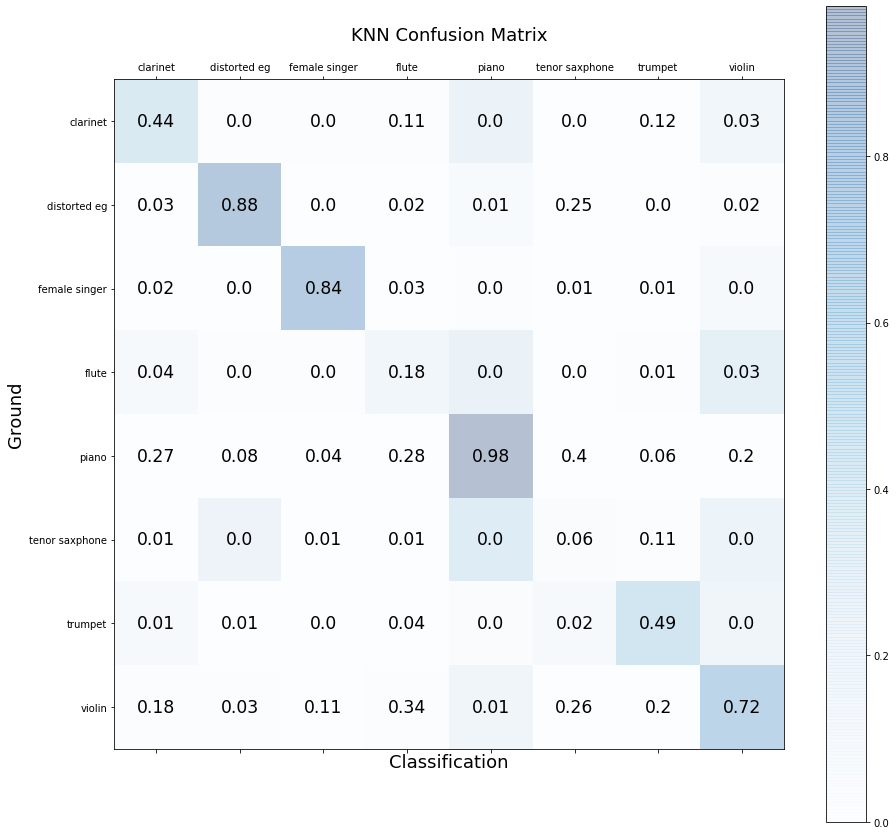

In [ ]:
print(f'knn f1 score: {knn_f1}')
instruments = ['clarinet', 'distorted eg', 'female singer', 'flute', 'piano', 'tenor saxphone', 'trumpet', 'violin']

fig, ax = plt.subplots(figsize=(15, 15))
cax = ax.matshow(knn_cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(knn_cm.shape[0]):
    for j in range(knn_cm.shape[1]):
        ax.text(x=i, y=j,s=knn_cm[i, j], va='center', ha='center', size='xx-large')

fig.colorbar(cax)
ax.set_xticklabels([''] + instruments)
ax.set_yticklabels([''] + instruments)
plt.xlabel('Classification', fontsize=18)
plt.ylabel('Ground', fontsize=18)
plt.title('KNN Confusion Matrix', fontsize=18)
plt.show()

## 4: Multi-Layer Perceptron (Neural Network)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

mlp = neural_network.MLPClassifier(max_iter=100, hidden_layer_sizes=(5, 2))
mlp.fit(train_norm, train_labels)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
# Validation
iter_range = list(range(100, 1001, 100))
hl_range = np.array([(100,), (50, 10, 3), (6, 4, 3)])
m_scores = np.array([])
i_index = 0
h_index = 0

for i in iter_range:
    for h in hl_range:
        mlp = neural_network.MLPClassifier(max_iter=i, hidden_layer_sizes=h)
        mlp_score = cross_val_score(mlp, validate_norm, validate_labels, scoring='f1_micro')
        m_scores = np.append(m_scores, mlp_score.mean())

print(f'mlp f1 scores: {m_scores}')
m_index = np.where(m_scores == m_scores.max())

if m_index[0].size >= 1:
    m_index = m_index[0][0]

i_index = int(m_index // len(iter_range))
h_index = int(m_index % hl_range.size - 1)
if h_index == -1:
    h_index = hl_range.size - 1

mlp = neural_network.MLPClassifier(max_iter=iter_range[i_index], hidden_layer_sizes=hl_range[h_index])
mlp.fit(train_norm, train_labels)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(6, 4, 3), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
mlp_result = mlp.predict(test_norm)
mlp_f1 = f1_score(test_labels, mlp_result, average='micro')
mlp_cm = confusion_matrix(test_labels, mlp_result, normalize='true')
mlp_cm = np.around(mlp_cm, 2)

mlp f1 score: 0.5451945080091534


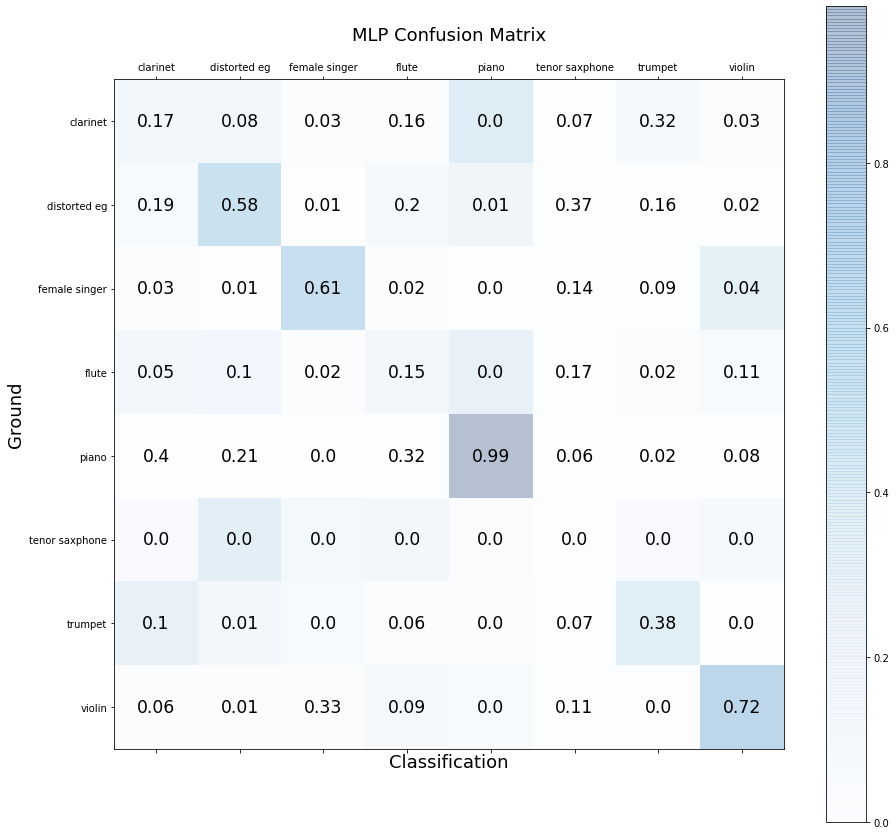

In [ ]:
print(f'mlp f1 score: {mlp_f1}')

fig2, ax2 = plt.subplots(figsize=(15, 15))
cax2 = ax2.matshow(mlp_cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(mlp_cm.shape[0]):
    for j in range(mlp_cm.shape[1]):
        ax2.text(x=i, y=j,s=mlp_cm[i, j], va='center', ha='center', size='xx-large')

fig2.colorbar(cax2)
ax2.set_xticklabels([''] + instruments)
ax2.set_yticklabels([''] + instruments)
plt.xlabel('Classification', fontsize=18)
plt.ylabel('Ground', fontsize=18)
plt.title('MLP Confusion Matrix', fontsize=18)
plt.show()

## 5. Analysis
Questeions to answer:

1. Which instrument class has the best & worst performance?
2. Worst source and commonly confused instruments?
3. Error Analysis: What do mistaken sources have in common?

### 1. Which instrument class has the best & worst performance?
For both the KNN model and the MLP model, **piano** performed the best, while **tenor saxphone** performed the worst.

## 2. Worst source and commonly confused instruments?
- For the worst source, tenor saxphone, sources of confusion are:
    - KNN model: distorted electric guitar, piano, violin (piano is most common)
    - MLP model: distorted electric guitar (most common)
- After listening to testing sound files and looking at the features we've choosen to use in training the KNN and MLP model, I think there are several reasons why:
    1. The handcrafted features used in this case was the mean and standard deviation of MFCCs, which is one of the feature used to extract timbre from a sound source. The distorted electric guitar has a significant amount of distortion while the saxphone also has quite a bit of noise caused by the way saxphone produces sounds. Violins can also have noise when bowing across the string at any pace.
    2. As for why piano is the most commonly mistaken instrument in the KNN model, the only reason I can think of is because of the frequency range of the piano recordings being in the higher frequency regions. Since there is a log calculation process when creating MFCCs, I guess it does put some emphasis on higher frequencies. The noise brass instruments make are also in the higher frequency region, which may cause the model to classify it as piano.
    3. Recording quality, quite a few tenor saxphone sound files are clearly recorded in 16 bit as oppose to 24 bit in other instruments which may cause the ML and DL model to miss classify.


## 3. Error Analysis: What do mistaken sources have in common?
Listening to the sound files, most of the confused instruments do have similar timbres. Similar to what has been mentioned in the last question, one of the reason is that the way the instruments produces sounds naturally have some noise in it. For example, distorted electric guitar and tenor saxphone. Or like the case of piano, the files consists of recordings that are higher in frequency.